In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 50)

## 1. Data Understanding

### 1.1 Data Loading

In [13]:
nih = pd.read_parquet('../data_analysis/nih_analysis.parquet', engine='fastparquet')
nsf = pd.read_parquet('../data_analysis/nsf_analysis.parquet', engine='fastparquet')

In [14]:
#nsf_raw = pd.read_csv('../data_raw/grant_witness_nsf_terminations.csv')
#nih_raw = pd.read_csv('../data_raw/grant_witness_nih_terminations.csv')

### 1.2 Column Categorization 

To understand the meaning of the columns better, we put them into more high-level groups and organize the data frames' columns into a corresponding multi-index. 

In [15]:
nsf.columns

Index(['grant_id', 'agcy_id', 'pi_names', 'pi_emails', 'title', 'abstract',
       'start_date', 'end_date', 'total_budget', 'amount_awarded', 'org_name',
       'org_state', 'was_cut', 'terminated', 'suspended', 'termination_date',
       'reinstated', 'reinstatement_date', 'nsf_url', 'usaspending_url',
       'award_type', 'division', 'directorate', 'nsf_program_name',
       'usasp_outlaid', 'estimated_remaining',
       'post_termination_deobligation'],
      dtype='object')

In [16]:
nsf.columns

Index(['grant_id', 'agcy_id', 'pi_names', 'pi_emails', 'title', 'abstract',
       'start_date', 'end_date', 'total_budget', 'amount_awarded', 'org_name',
       'org_state', 'was_cut', 'terminated', 'suspended', 'termination_date',
       'reinstated', 'reinstatement_date', 'nsf_url', 'usaspending_url',
       'award_type', 'division', 'directorate', 'nsf_program_name',
       'usasp_outlaid', 'estimated_remaining',
       'post_termination_deobligation'],
      dtype='object')

In [17]:
##################
#### NIH Data ####
##################

nih_column_mapping = {
    # Identification: Unique keys and external database links
    'application_id': 'id', 
    'core_project_num': 'id', 
    'reporter_url': 'id', 
    'usaspending_url': 'id',
    
    # Context: The administrative, institutional, and political ecosystem
    'administering_ic': 'context', 
    'administering_ic_name': 'context',
    'study_section': 'context', 
    'study_section_name': 'context',
    'pi_names': 'context', 
    'org_name': 'context', 
    'org_dept': 'context', 
    'organization_type': 'context', 
    'org_state': 'context', 
    'congressional_district': 'context', 
    'us_rep': 'context',
    
    # Content: Scientific substance and research focus
    'project_title': 'content', 
    'project_abstract': 'content', 
    'project_terms': 'content', 
    'public_health_relevance': 'content',
    'nih_spending_categorization': 'content', 
    'flagged_words': 'content',
    
    # Time: Temporal data regarding the grant lifecycle
    'fiscal_year': 'time', 
    'project_start': 'time', 
    'project_end': 'time',
    'targeted_start_date': 'time', 
    'targeted_end_date': 'time', 
    'frozen_date': 'time', 
    'unfrozen_date': 'time', 
    'termination_date': 'time',
    'reinstated_est_date': 'time',
    
    # Finance: Budgetary figures and spending metrics
    'total_cost': 'finance', 
    'total_estimated_outlays': 'finance', 
    'total_estimated_remaining': 'finance', 
    'last_payment_date': 'finance',
    
    # Status: Indicators of termination and reinstatement
    'status': 'status', 
    'ever_frozen': 'status', 
    'reinstatement_indicator': 'status',
    'cancellation_source': 'status'
}

nih.columns = pd.MultiIndex.from_tuples(
    [(nih_column_mapping.get(col, 'Other'), col) for col in nih.columns],
    names=['category', 'variable']
)

In [18]:
##################
#### NSF Data ####
##################

nsf_column_mapping = {
    # Identification: IDs and technical links
    'grant_id': 'id',
    'agcy_id': 'id',
    'nsf_url': 'id',
    'usaspending_url': 'id',
    
    # Context: Institutional and organizational structure
    'pi_names': 'context',
    'pi_emails': 'context',
    'org_name': 'context',
    'org_state': 'context',
    'division': 'context', 
    'directorate': 'context',
    'nsf_program_name': 'context',
    'award_type': 'context',   
    
    # Content: Scientific substance
    'title': 'content',
    'abstract': 'content',
    
    # Time: Temporal grant lifecycle
    'start_date': 'time',
    'end_date': 'time',
    'termination_date': 'time',
    'reinstatement_date': 'time',
    
    # Finance: Budgetary metrics
    'total_budget': 'finance',
    'amount_awarded': 'finance',
    'usasp_outlaid': 'finance',
    'estimated_remaining': 'finance',
    'post_termination_deobligation': 'finance',
    
    # Status: Termination indicators
    'was_cut': 'status',
    'terminated': 'status',
    'suspended': 'status',
    'reinstated': 'status'
}

nsf.columns = pd.MultiIndex.from_tuples(
    [(nsf_column_mapping.get(col, 'Other'), col) for col in nsf.columns],
    names=['Category', 'Variable']
)

### 1.3 Column Summary

In [19]:
from pandas.api.types import is_numeric_dtype, is_bool_dtype

def feature_summary(data):

    def count_outliers_iqr(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        return len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])

    summary = pd.DataFrame({
        'category': [], 'variable': [], 'datatype': [], 'missing_val_count': [], 'missing_val_pct': [], 'existing_val_count': [], 'distinct_val_count': [],
        'mode': [], 'mean': [], 'std': [], 'q25': [], 'median': [], 'q75': [], 'outliers': []
    })
    for col in data.columns:
        summary = pd.concat([summary, pd.DataFrame({
        'category': [col[0]], 
        'variable': [col[1]], 
        'datatype': [data[col].dtype], 
        'missing_val_count': [sum(data[col].isna())],
        'missing_val_pct': [sum(data[col].isna()) / len(data)], 
        'existing_val_count': [sum((data[col].isna() == False))], 
        'distinct_val_count': [data[col].value_counts().count()],
        'mode': [list(data[col].mode().values) if len(list(data[col].mode().values)) > 1 else data[col].mode()[0]], 
        'mean': [round(data[col].mean(), 2) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
        'std': [round(data[col].std(), 2) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
        'q25': [round(data[col].quantile(0.25), 2) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
        'median': [round(data[col].median(), 2) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
        'q75': [round(data[col].quantile(0.75), 2) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
        'outliers': [count_outliers_iqr(data, col) if is_numeric_dtype(data[col]) and not is_bool_dtype(data[col]) else np.nan], 
    })])

    summary['category'] = pd.Categorical(summary['category'], categories=['id', 'status', 'context', 'time', 'finance', 'content'], ordered=True)   
    summary.sort_values('category', inplace=True) 
    return summary

In [20]:
# type conversion
nih['id'] = nih['id'].astype('string')

nih[('status', 'reinstatement_indicator')] = nih[('status', 'reinstatement_indicator')].astype('string')
nih[('status', 'ever_frozen')] = nih[('status', 'ever_frozen')].astype('boolean')
nih[('status', 'cancellation_source')] = nih[('status', 'cancellation_source')].astype('string')
nih[('status', 'status')] = nih[('status', 'status')].astype('string')

nih['context'] = nih['context'].astype('string')

nih[('time', 'fiscal_year')] = nih[('time', 'fiscal_year')].astype('string')

nih['content'] = nih['content'].astype('string')

In [21]:
nih_summary = feature_summary(nih)
nih_summary

,category,variable,datatype,missing_val_count,missing_val_pct,existing_val_count,distinct_val_count,mode,mean,std,q25,median,q75,outliers
0,id,application_id,string[python],0.0,0.000000,230456.0,230430.0,"[10880498.0, 10888305.0]",NaN,NaN,NaN,NaN,NaN,NaN
0,id,usaspending_url,string[python],224642.0,0.974772,5814.0,5788.0,[https://www.usaspending.gov/award/ASST_NON_R0...,NaN,NaN,NaN,NaN,NaN,NaN
0,id,reporter_url,string[python],224642.0,0.974772,5814.0,5805.0,https://reporter.nih.gov/project-details/NA,NaN,NaN,NaN,NaN,NaN,NaN
0,id,core_project_num,string[python],1.0,0.000004,230455.0,230429.0,"[R01HD094731, UM1MH130981]",NaN,NaN,NaN,NaN,NaN,NaN
0,status,reinstatement_indicator,string[python],227916.0,0.988978,2540.0,29.0,"AAUP-Harvard v DOJ, Harvard v HHS",NaN,NaN,NaN,NaN,NaN,NaN
0,status,status,string[python],224642.0,0.974772,5814.0,5.0,Possibly Reinstated,NaN,NaN,NaN,NaN,NaN,NaN
0,status,ever_frozen,boolean,224642.0,0.974772,5814.0,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN
0,status,cancellation_source,string[python],224642.0,0.974772,5814.0,5.0,No USAspending payments,NaN,NaN,NaN,NaN,NaN,NaN
0,context,administering_ic_name,string[python],55033.0,0.238800,175423.0,47.0,NATIONAL CANCER INSTITUTE,NaN,NaN,NaN,NaN,NaN,NaN
0,context,administering_ic,string[python],0.0,0.000000,230456.0,82.0,CA,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# type conversion
nsf['id'] = nsf['id'].astype('string')
nsf['status'] = nsf['status'].astype('boolean')
nsf['context'] = nsf['context'].astype('string')
nsf['content'] = nsf['content'].astype('string')

In [23]:
nsf_summary = feature_summary(nsf)
nsf_summary

,category,variable,datatype,missing_val_count,missing_val_pct,existing_val_count,distinct_val_count,mode,mean,std,q25,median,q75,outliers
0,id,grant_id,string[python],0.0,0.000000,130204.0,130204.0,"[1062661, 1127821, 1153441, 1154283, 1154735, ...",NaN,NaN,NaN,NaN,NaN,NaN
0,id,agcy_id,string[python],0.0,0.000000,130204.0,1.0,NSF,NaN,NaN,NaN,NaN,NaN,NaN
0,id,usaspending_url,string[python],128314.0,0.985484,1890.0,1890.0,[https://www.usaspending.gov/award/ASST_NON_14...,NaN,NaN,NaN,NaN,NaN,NaN
0,id,nsf_url,string[python],128314.0,0.985484,1890.0,1890.0,[https://www.nsf.gov/awardsearch/show-award?AW...,NaN,NaN,NaN,NaN,NaN,NaN
0,status,reinstated,boolean,128314.0,0.985484,1890.0,2.0,False,NaN,NaN,NaN,NaN,NaN,NaN
0,status,suspended,boolean,128912.0,0.990077,1292.0,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN
0,status,was_cut,boolean,0.0,0.000000,130204.0,2.0,False,NaN,NaN,NaN,NaN,NaN,NaN
0,status,terminated,boolean,128314.0,0.985484,1890.0,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN
0,context,org_name,string[python],2.0,0.000015,130202.0,8992.0,Regents of the University of Michigan - Ann Arbor,NaN,NaN,NaN,NaN,NaN,NaN
0,context,org_state,string[python],172.0,0.001321,130032.0,58.0,California,NaN,NaN,NaN,NaN,NaN,NaN


### 1.4 Data Quality Checks

#### Reliability of total budget information

In [262]:
nih[('finance', 'check_sum')] = nih[('finance', 'total_estimated_outlays')] + nih[('finance', 'total_estimated_remaining')]

cost = nih[('finance', 'total_cost')]
check = nih[('finance', 'check_sum')]

total_cost_false = len(nih[(cost > 1.1 * check) | (cost < 0.9 * check)]['finance'])
total_cost_correct = len(nih[(cost < 1.1 * check) & (cost > 0.9 * check)]['finance'])

grant_witness_mask = nih[('status', 'status')].isna() == False
missing_fin_inf_mask = (nih[('finance', 'total_estimated_outlays')].isna() == True) | (nih[('finance', 'total_estimated_remaining')].isna() == True)
missing_total_cost_mask = cost.isna() == True

print(f"Total entries NIH data: {len(nih)}")
print(f"NIH entries from grant-witness.us: {len(nih[grant_witness_mask])}")
print("----------------------------------")
print(f"NIH entries without total_cost info: {sum(cost.isna())}")
print(f"NIH grant-witness.us entries without total_cost info: {len(nih[grant_witness_mask & (missing_total_cost_mask)])}")
print(f"NIH grant-witness.us entries without further financial information: {len(nih[grant_witness_mask & missing_fin_inf_mask])}")
print("----------------------------------")
print(f"Entries where total_cost equals sum of grant-witness.us financial info: {total_cost_correct}")
print(f"Entries where total_cost does not equal sum of grant-witness.us financial info: {total_cost_false}")
print("----------------------------------")
print("----------------------------------")

pd.DataFrame({
    'measure': ['entries with total_cost info', 'grant-witness entries with correct total_cost info'],
    'value': [1 - (sum(cost.isna()) / len(nih)), (total_cost_correct / len(nih[grant_witness_mask]))]
})

Total entries NIH data: 230456
NIH entries from grant-witness.us: 5814
----------------------------------
NIH entries without total_cost info: 9920
NIH grant-witness.us entries without total_cost info: 112
NIH grant-witness.us entries without further financial information: 55
----------------------------------
Entries where total_cost equals sum of grant-witness.us financial info: 551
Entries where total_cost does not equal sum of grant-witness.us financial info: 5096
----------------------------------
----------------------------------


,measure,value
0,entries with total_cost info,0.956955
1,grant-witness entries with correct total_cost ...,0.094771


In [475]:
nsf[('finance', 'check_sum')] = nsf[('finance', 'usasp_outlaid')] + nsf[('finance', 'estimated_remaining')]

cost = nsf[('finance', 'total_budget')]
check = nsf[('finance', 'check_sum')]

total_cost_false = len(nsf[(cost > 1.1 * check) | (cost < 0.9 * check)]['finance'])
total_cost_correct = len(nsf[(cost < 1.1 * check) & (cost > 0.9 * check)]['finance'])

grant_witness_mask = nsf[('status', 'terminated')].isna() == False
missing_fin_inf_mask = (nsf[('finance', 'usasp_outlaid')].isna() == True) | (nsf[('finance', 'estimated_remaining')].isna() == True)
missing_total_cost_mask = cost.isna() == True

print(f"Total entries NIH data: {len(nsf)}")
print(f"NIH entries from grant-witness.us: {len(nsf[grant_witness_mask])}")
print("----------------------------------")
print(f"NIH entries without total_budget info: {sum(cost.isna())}")
print(f"NIH grant-witness.us entries without total_budget info: {len(nsf[grant_witness_mask & (missing_total_cost_mask)])}")
print(f"NIH grant-witness.us entries without further financial information: {len(nsf[grant_witness_mask & missing_fin_inf_mask])}")
print("----------------------------------")
print(f"Entries where total_budget equals sum of grant-witness.us financial info: {total_cost_correct}")
print(f"Entries where total_budget does not equal sum of grant-witness.us financial info: {total_cost_false}")
print("----------------------------------")
print("----------------------------------")

pd.DataFrame({
    'measure': ['entries with total_budget info', 'grant-witness entries with correct total_budget info'],
    'value': [1 - (sum(cost.isna()) / len(nsf)), (total_cost_correct / len(nsf[grant_witness_mask]))]
})

Total entries NIH data: 130204
NIH entries from grant-witness.us: 1890
----------------------------------
NIH entries without total_budget info: 2
NIH grant-witness.us entries without total_budget info: 0
NIH grant-witness.us entries without further financial information: 90
----------------------------------
Entries where total_budget equals sum of grant-witness.us financial info: 1706
Entries where total_budget does not equal sum of grant-witness.us financial info: 94
----------------------------------
----------------------------------


,measure,value
0,entries with total_budget info,0.999985
1,grant-witness entries with correct total_budge...,0.902646


### 1.5 Looking at the data

In [42]:
import matplotlib.pyplot as plt
import math

def plot_features(data, data_summary, figsize, categorical_cols = [], outlier_robust = True):    
    numerical_cols = [(col[1]['category'], col[1]['variable']) for col in data_summary.iterrows() if col[1]['datatype'] == 'float64']
    #max_categories = 15
    #categorical_cols = [(col[1]['category'], col[1]['variable']) for col in data_summary.iterrows() if (col[1]['datatype'] != 'float64') and (len(data[(col[1]['category'], col[1]['variable'])].value_counts()) <= max_categories)]
    col_names = numerical_cols + categorical_cols

    num_plots = len(col_names)
    ncols = 3
    nrows = math.ceil(num_plots / 3)

    i = 0
    for row in range(0, nrows):
        fig, ax = plt.subplots(1, ncols, figsize=figsize)
        for col in range(0, ncols):
            try:
                dat_plot = data[col_names[i]]
                dat_plot = dat_plot[dat_plot.isna() == False]
                if dat_plot.dtype == 'boolean':
                    dat_plot = dat_plot.astype('int64')

                if col_names[i] in categorical_cols:
                    dat_plot = dat_plot.value_counts()
                    if outlier_robust:
                        dat_plot = dat_plot[0:15]
                    dat_plot.plot(kind='bar', ax=ax[col])
                    if dat_plot.dtype != 'int64':
                        ax[col].set_title(f"{col_names[i][1]} (top 15 values)")
                    else:
                        ax[col].set_title(f"{col_names[i][1]}") 
                    ax[col].tick_params(axis='x', labelrotation=90)
                    ax[col].set_xlabel("")

                else:
                    if outlier_robust:
                        dat_plot = dat_plot[dat_plot < dat_plot.quantile(.95)]
                    ax[col].hist(dat_plot, bins='fd')
                    ax[col].set_title(f"{col_names[i][1]}")
                i += 1
            except:
                i += 1
                
        plt.tight_layout()
        plt.show()

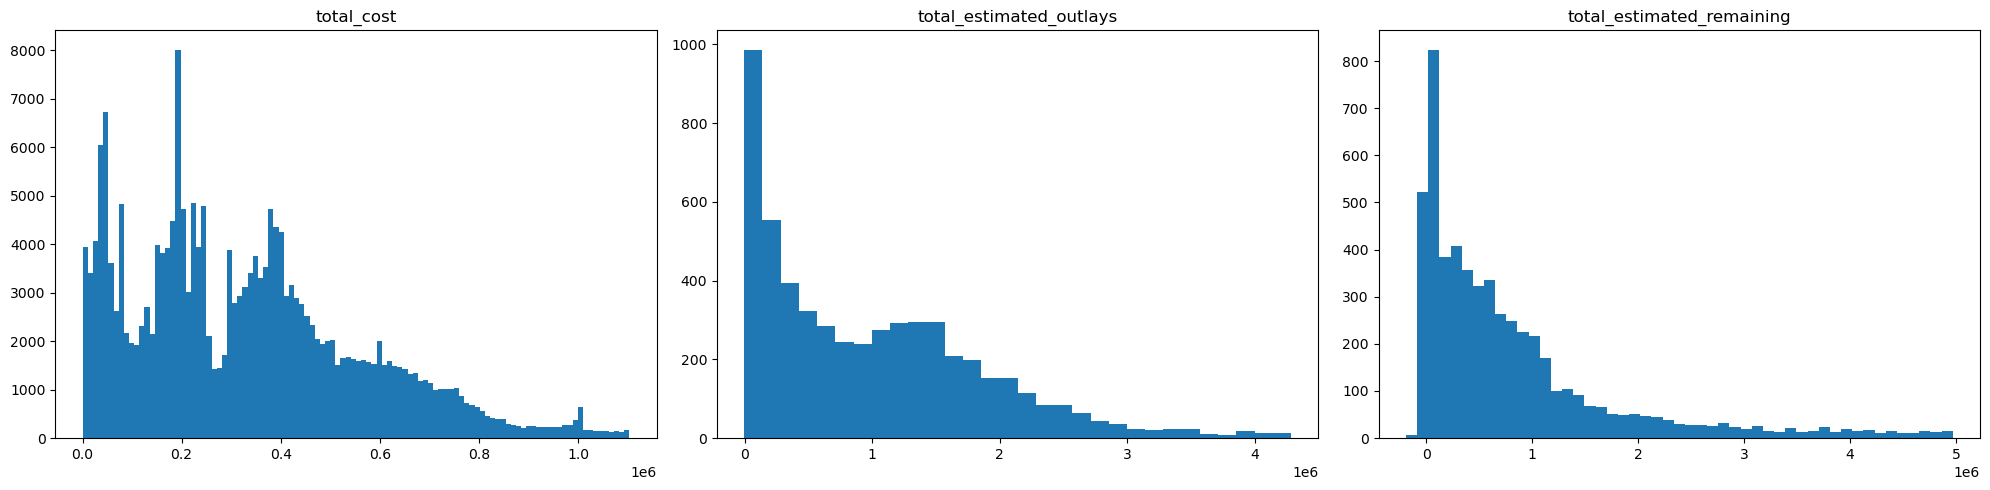

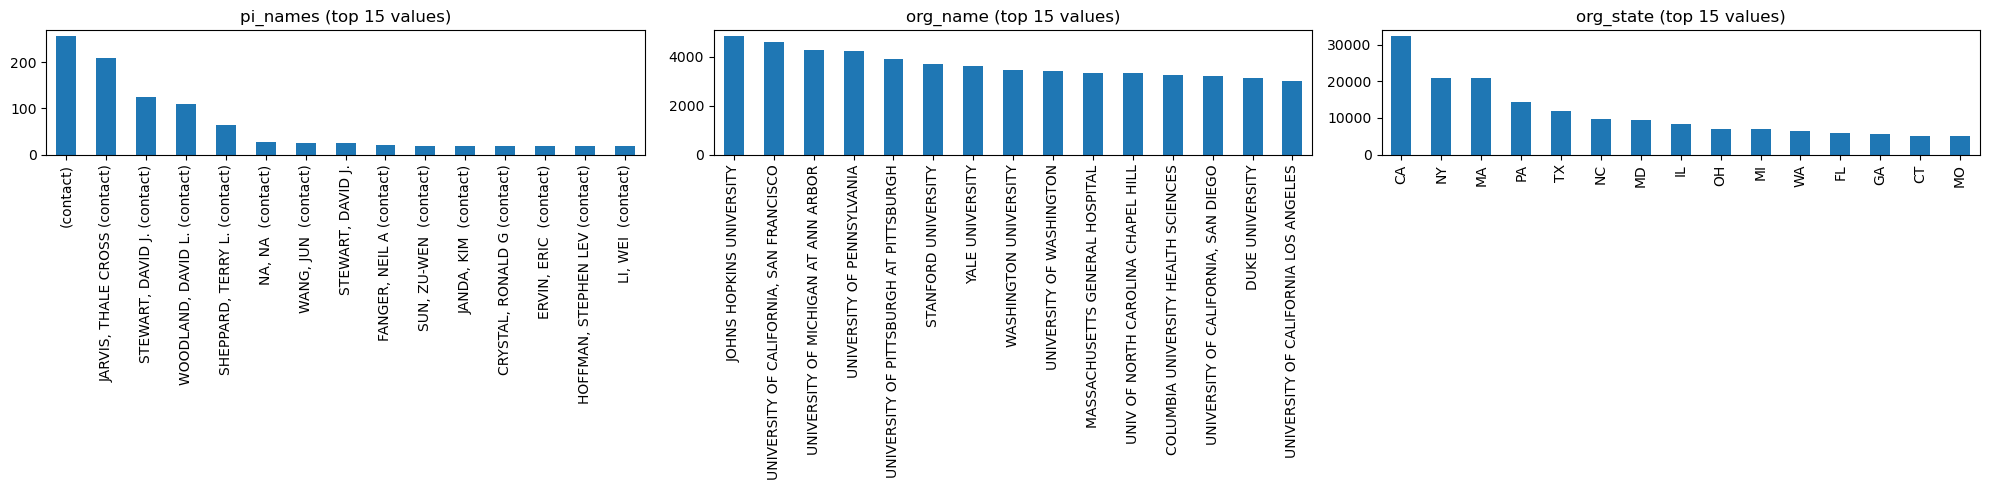

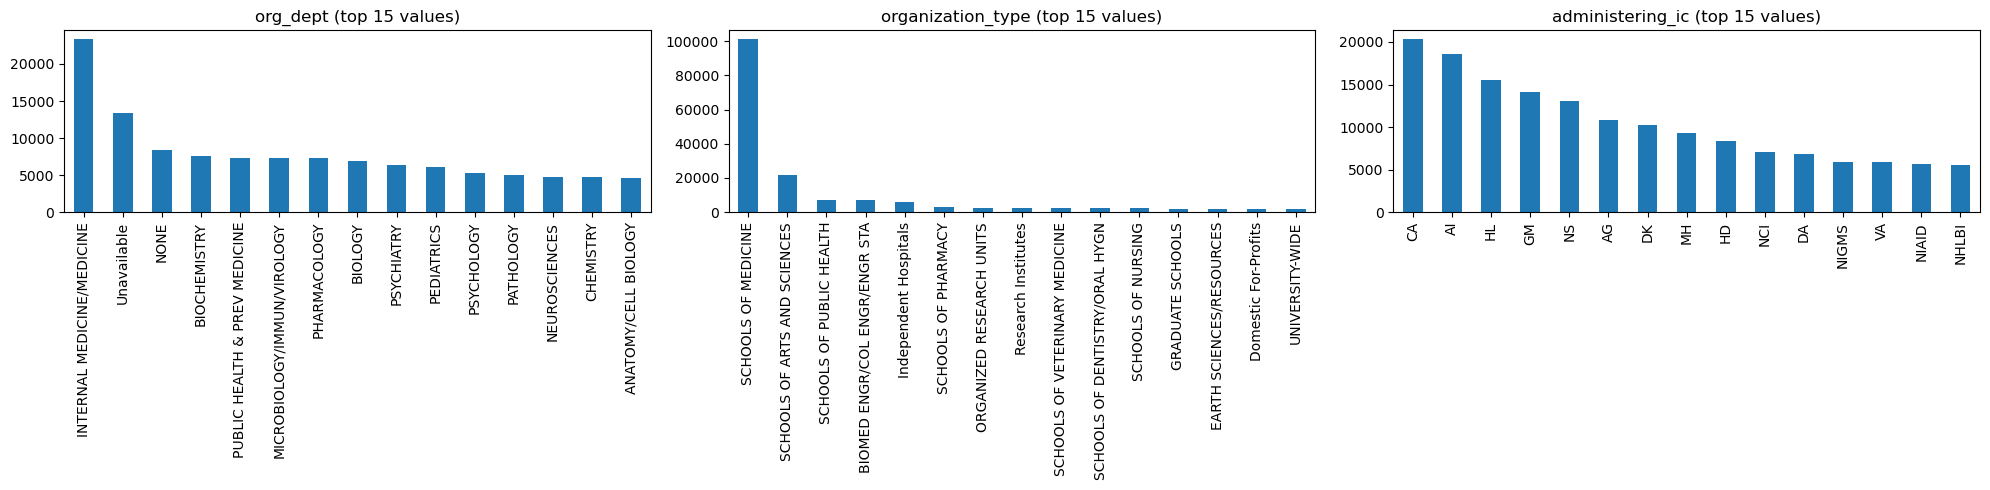

/var/folders/3_/4191z6q51251z9ggjkycrb5m0000gn/T/ipykernel_79901/3894587361.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


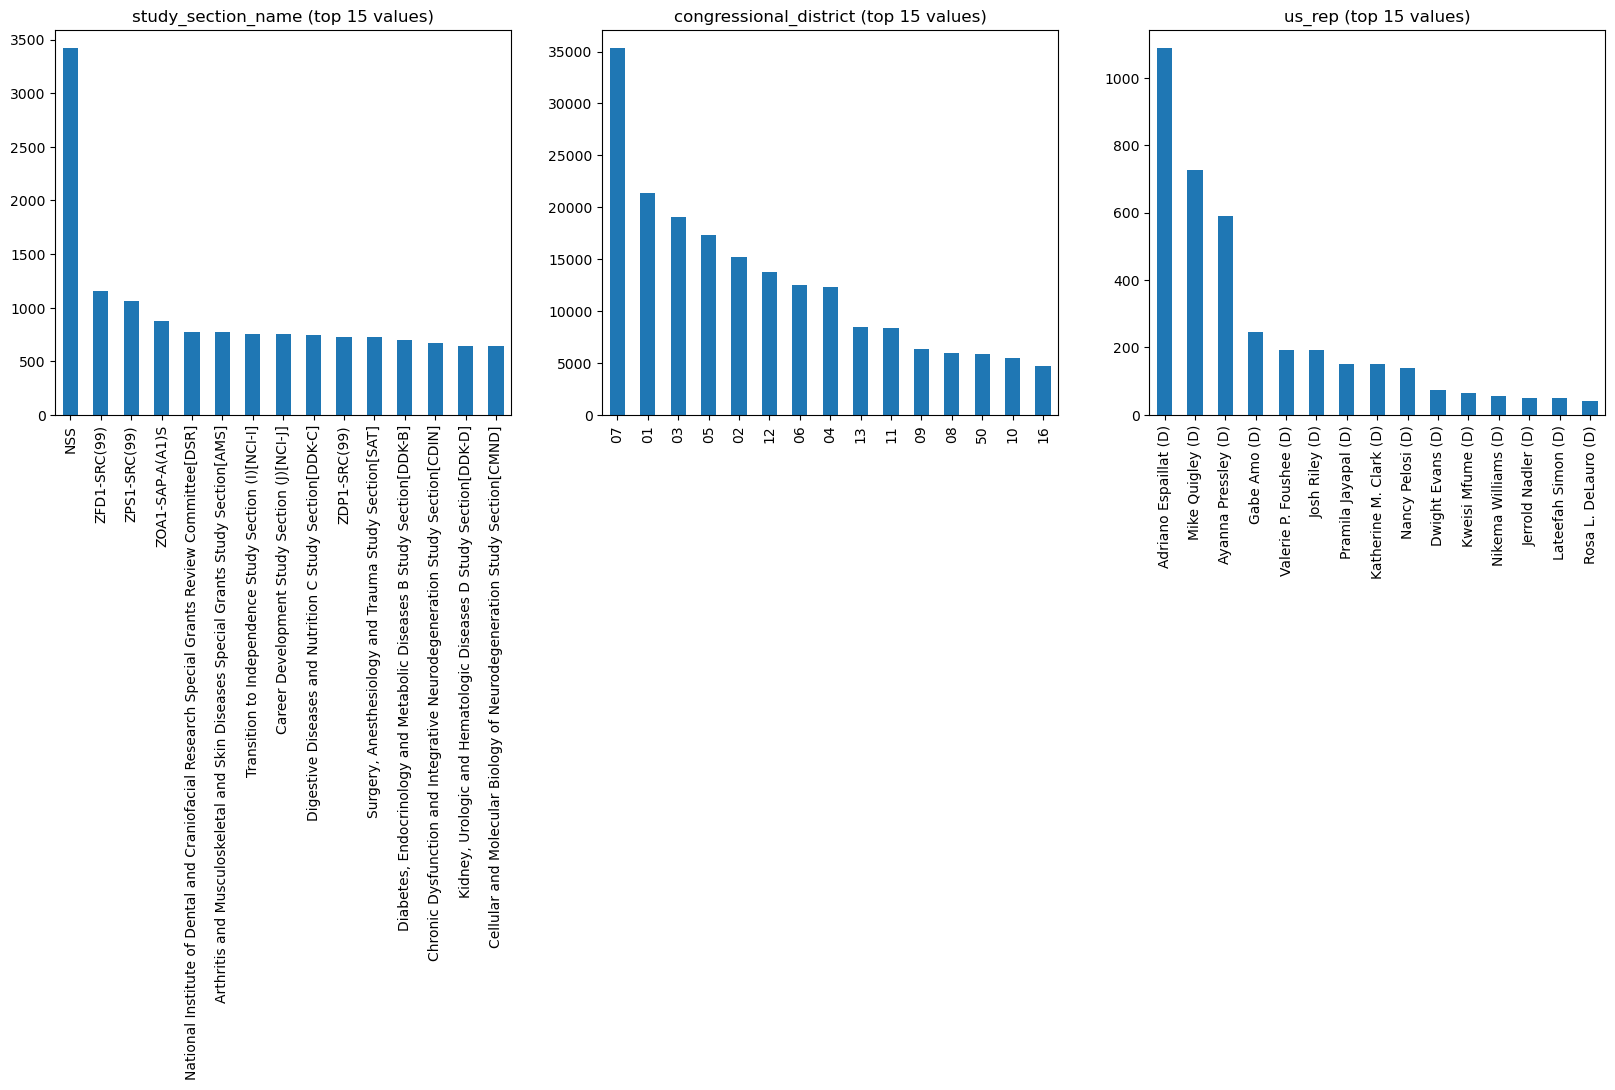

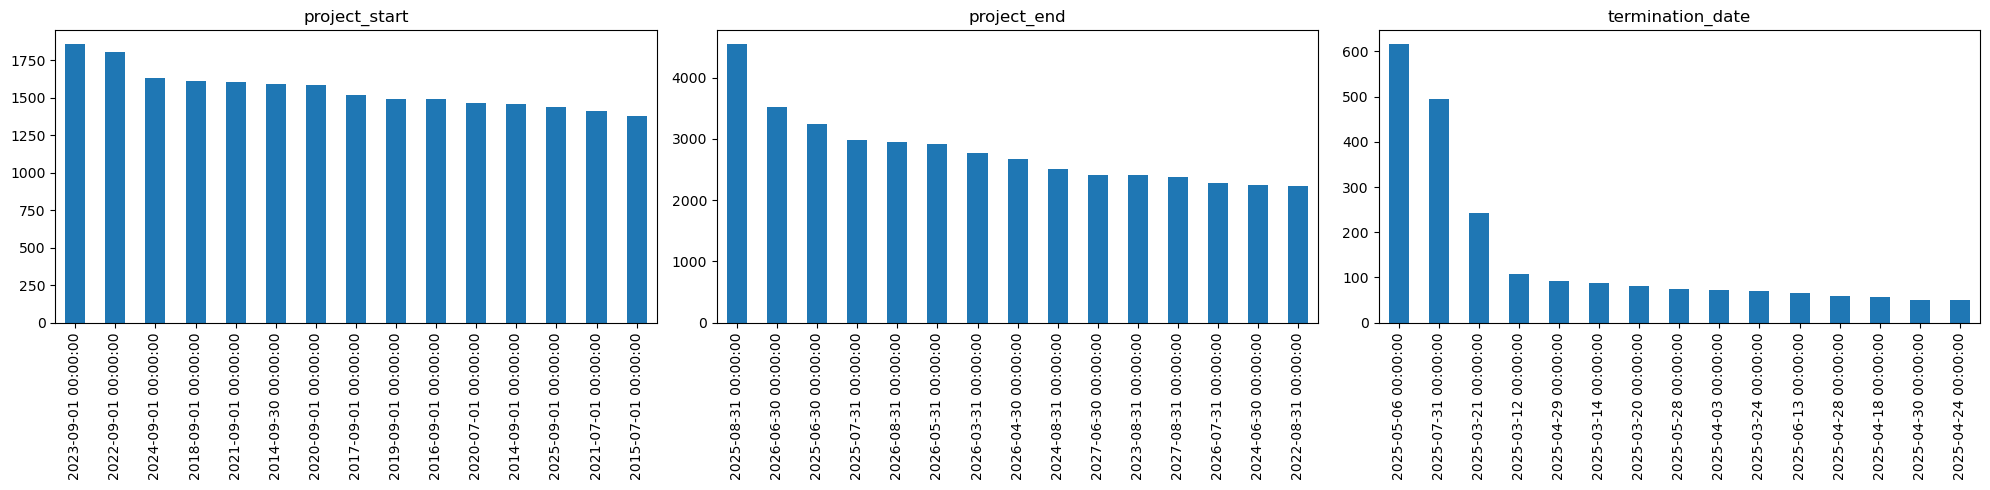

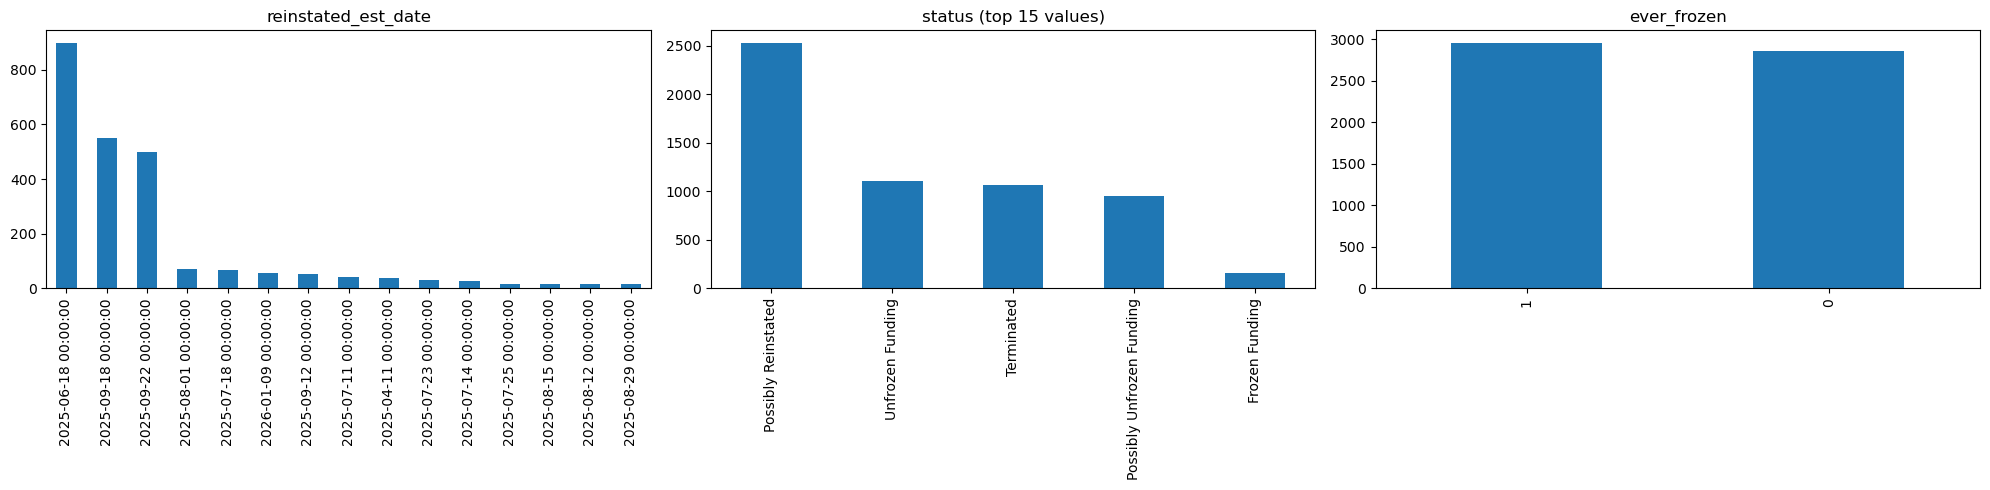

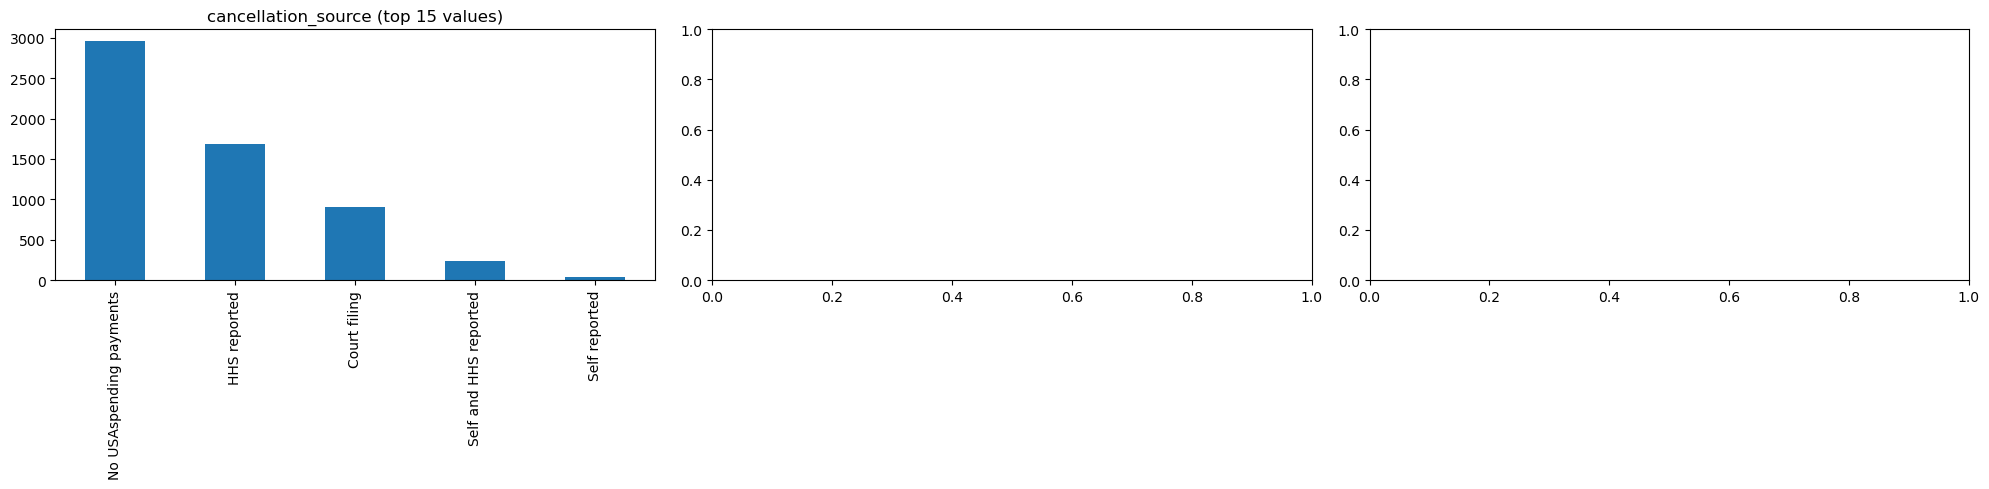

In [43]:
plot_features(nih, nih_summary, figsize=(20,5), categorical_cols=[
    ('context', 'pi_names'),
    ('context', 'org_name'),
    ('context', 'org_state'),
    ('context', 'org_dept'),
    ('context', 'organization_type'),
    ('context', 'administering_ic'),
    ('context', 'study_section_name'),
    ('context', 'congressional_district'),
    ('context', 'us_rep'),
    ('time', 'project_start'),
    ('time', 'project_end'),
    ('time', 'termination_date'),
    ('time', 'reinstated_est_date'),
    ('status', 'status'),
    ('status', 'ever_frozen'),
    ('status', 'cancellation_source')
    ])

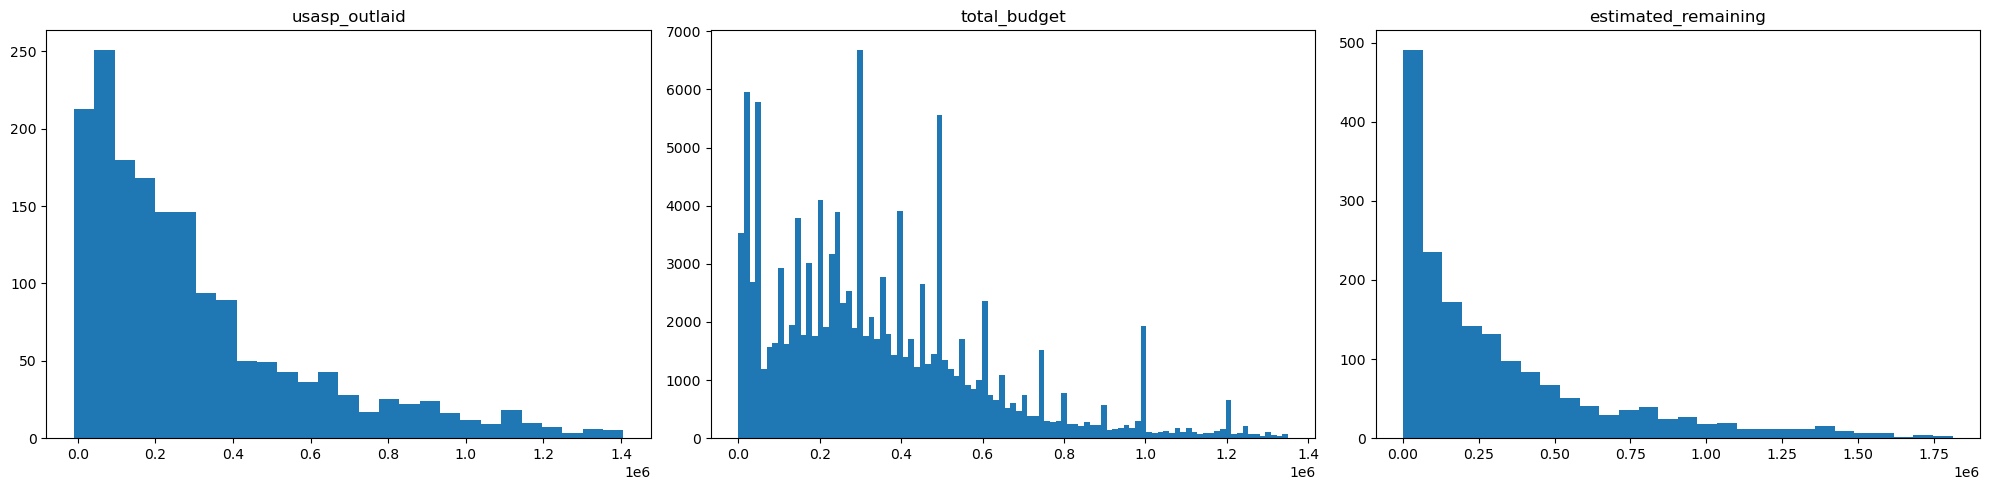

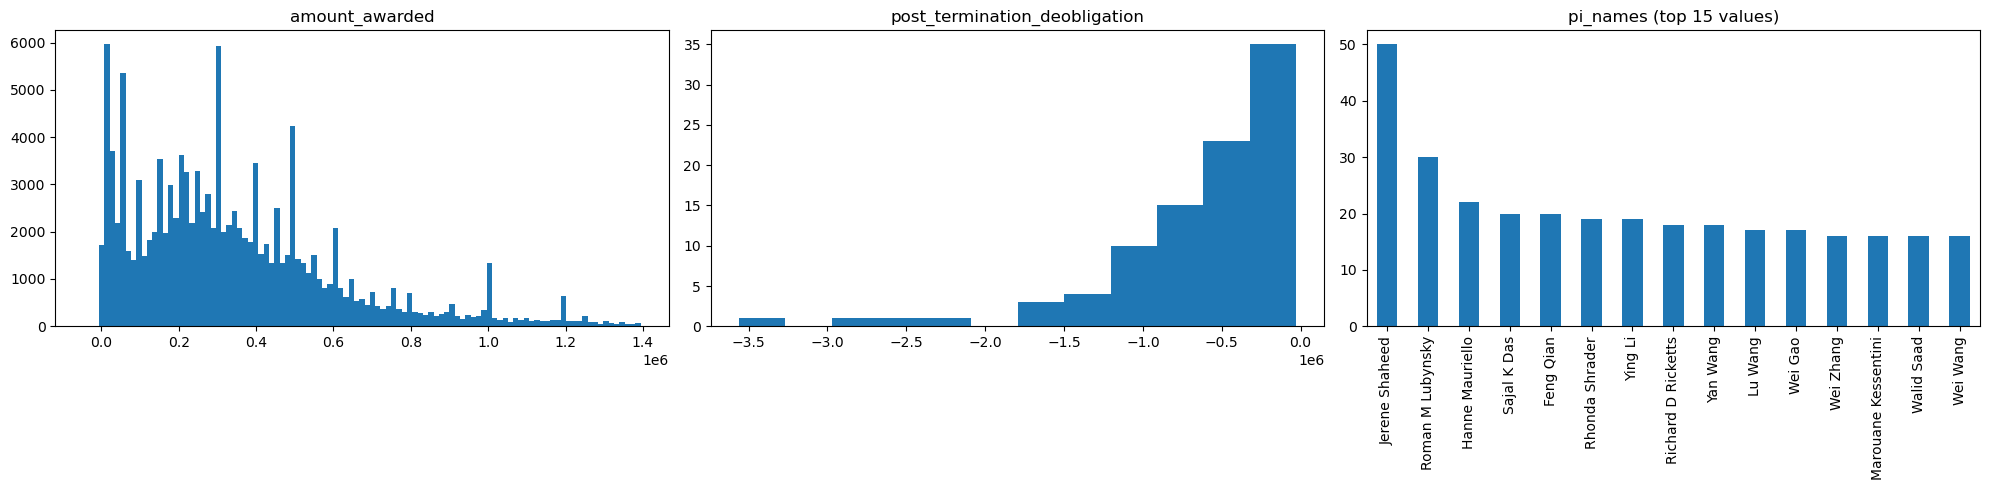

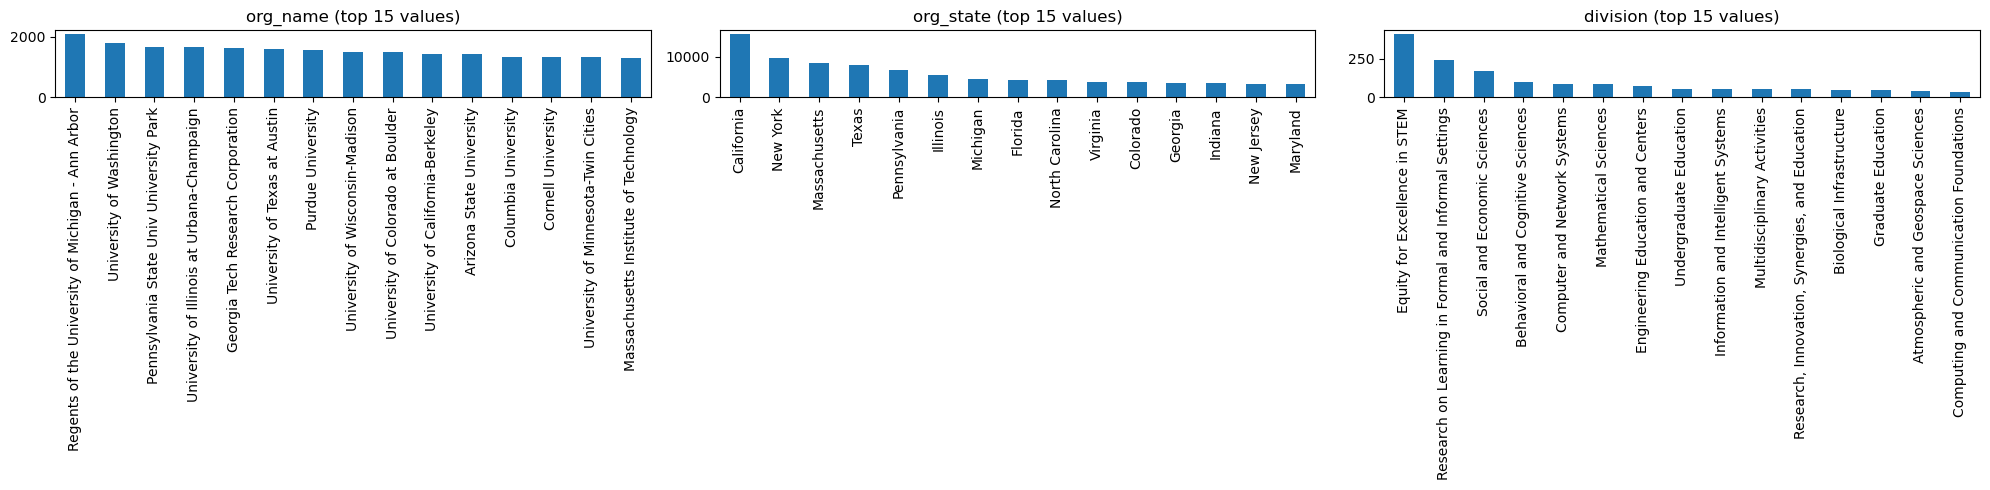

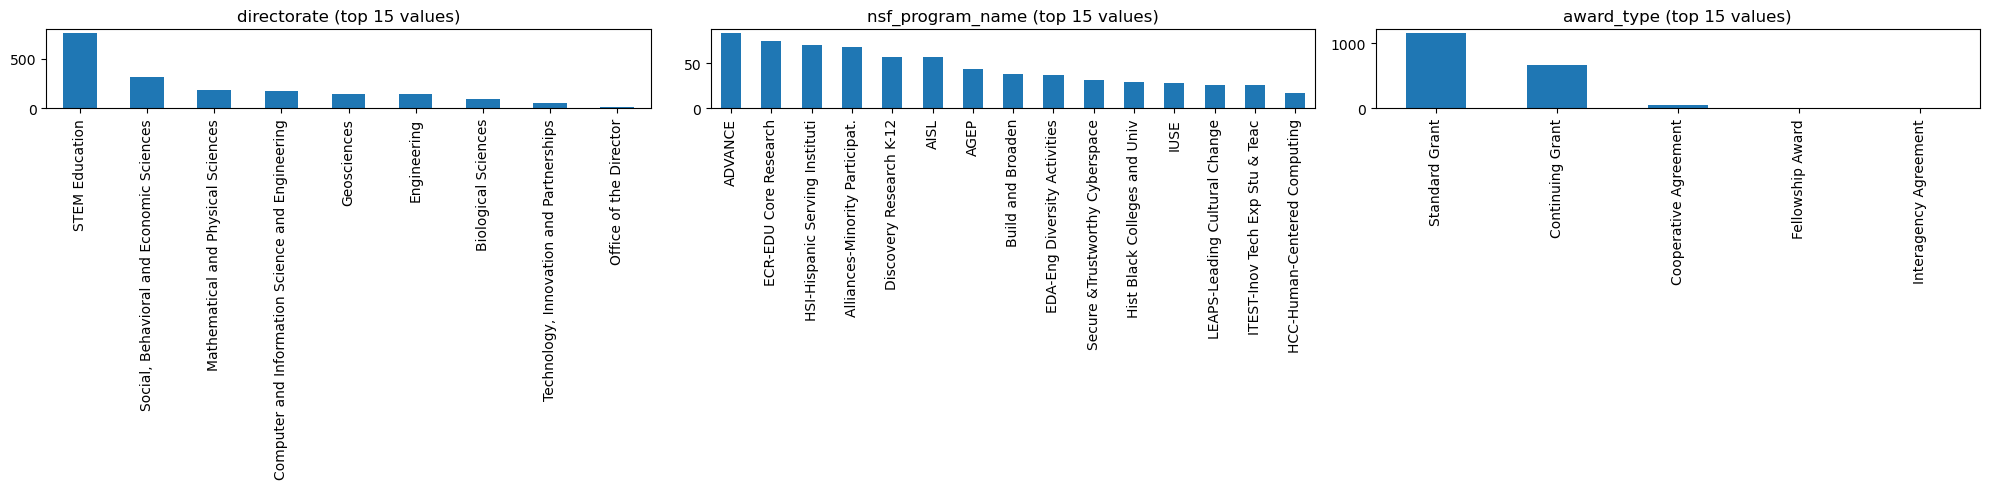

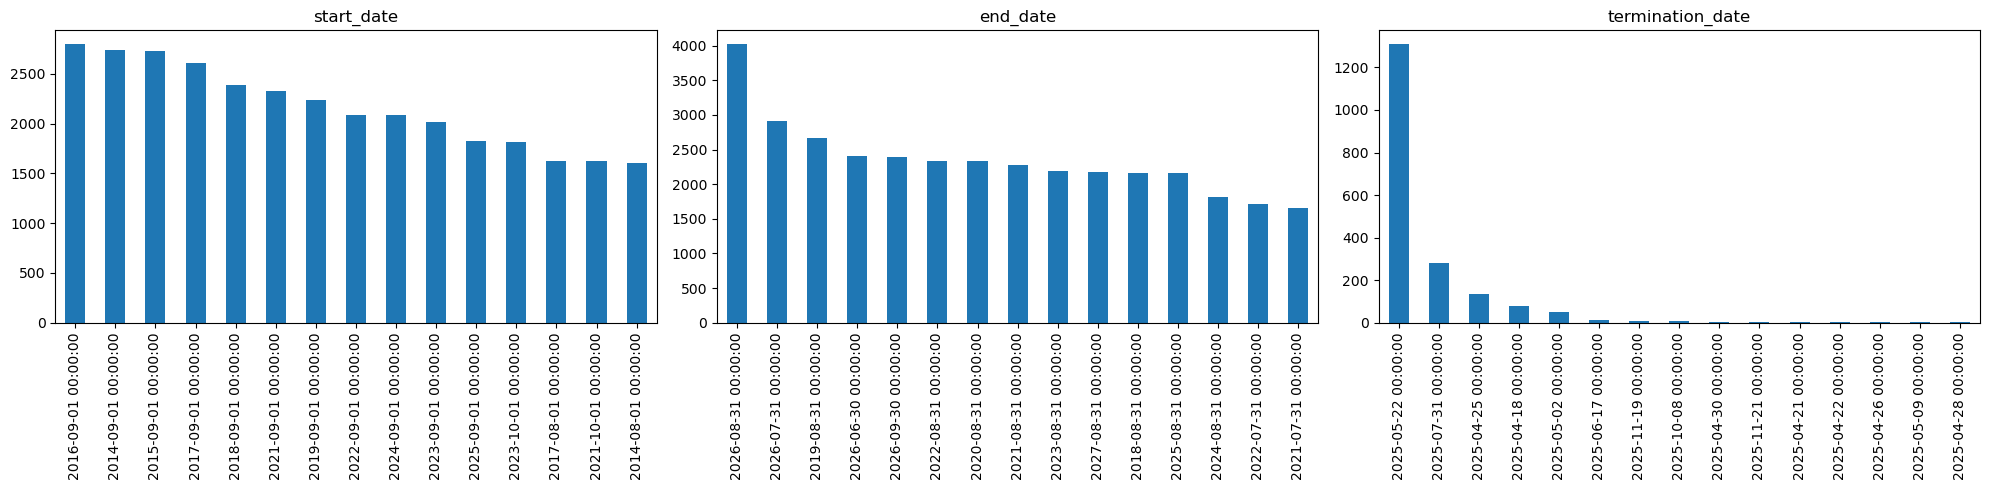

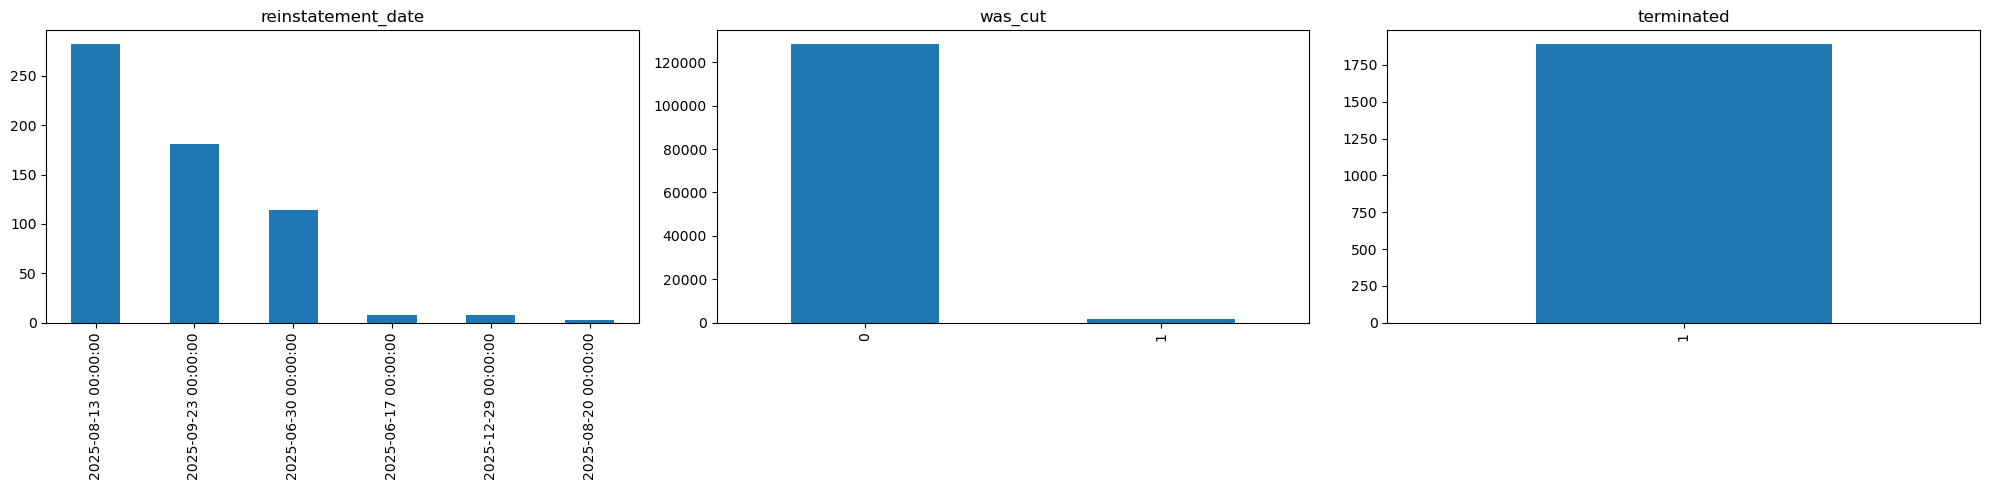

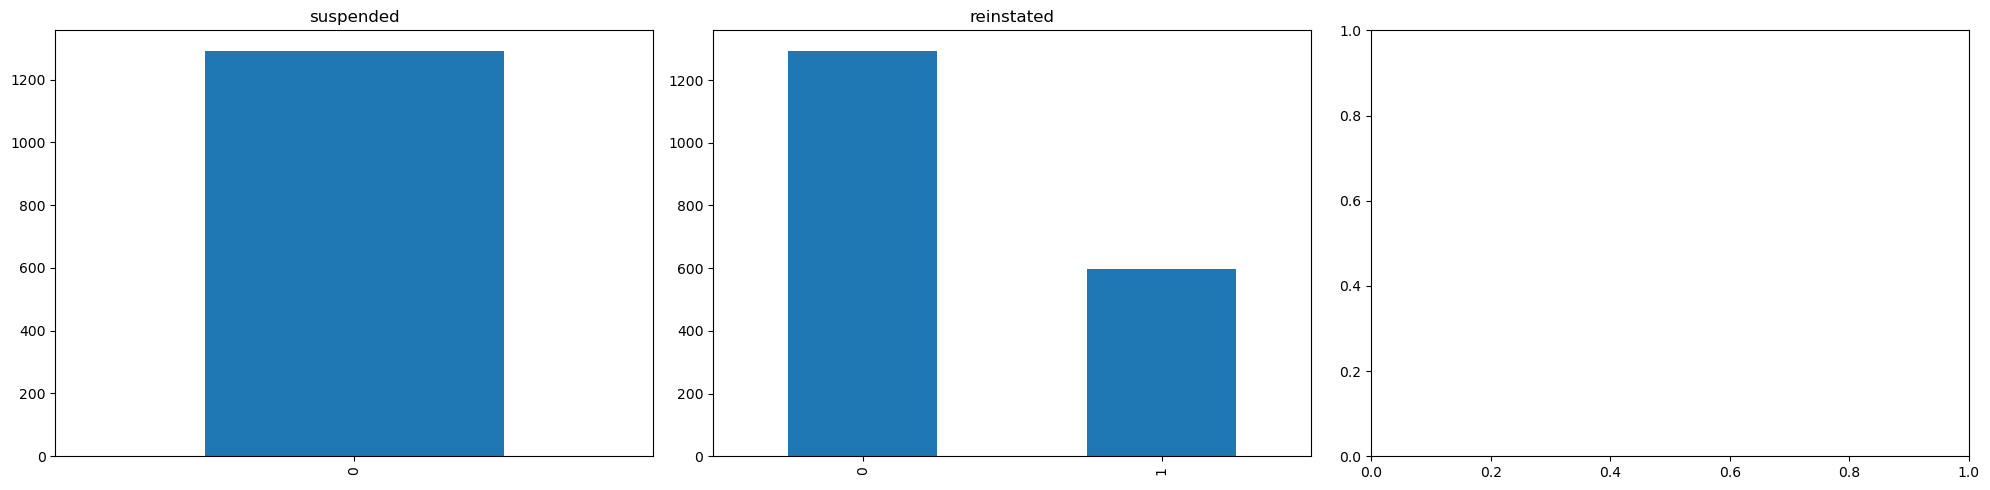

In [44]:
plot_features(nsf, nsf_summary, figsize=(20, 5), categorical_cols=[
        ('context', 'pi_names'),
        ('context', 'org_name'),
        ('context', 'org_state'),
        ('context', 'division'),
        ('context', 'directorate'),
        ('context', 'nsf_program_name'),
        ('context', 'award_type'),
        ('time', 'start_date'),
        ('time', 'end_date'),
        ('time', 'termination_date'),
        ('time', 'reinstatement_date'),
        ('status', 'was_cut'),
        ('status', 'terminated'),
        ('status', 'suspended'),
        ('status', 'reinstated')
    ])